In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [3]:
Image_Size=256
Batch_Size=32
Epochs=5
Channels=3

In [5]:
dataset=tf.keras.preprocessing.image_dataset_from_directory("D:\Machine Vision Project\potato_disease\PlantVillage",
batch_size=Batch_Size,
image_size=(Image_Size,Image_Size),
shuffle=True)

Found 2152 files belonging to 3 classes.


In [6]:
class_name=dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
for image_batch, labels_batch in dataset.take(1):#dataset.take(n)--->n of batch
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 1 0 0 0 0 0 0 0 1 0 1 1 0 1 0 2 0 2 1 1 1 0 1 0 1 0 0 1 2 0 1]


In [8]:
# transformation
data_augumentation=tf.keras.Sequential([layers.RandomFlip("horizontal_and_vertical")])

<!-- 3 is for rgb  -->

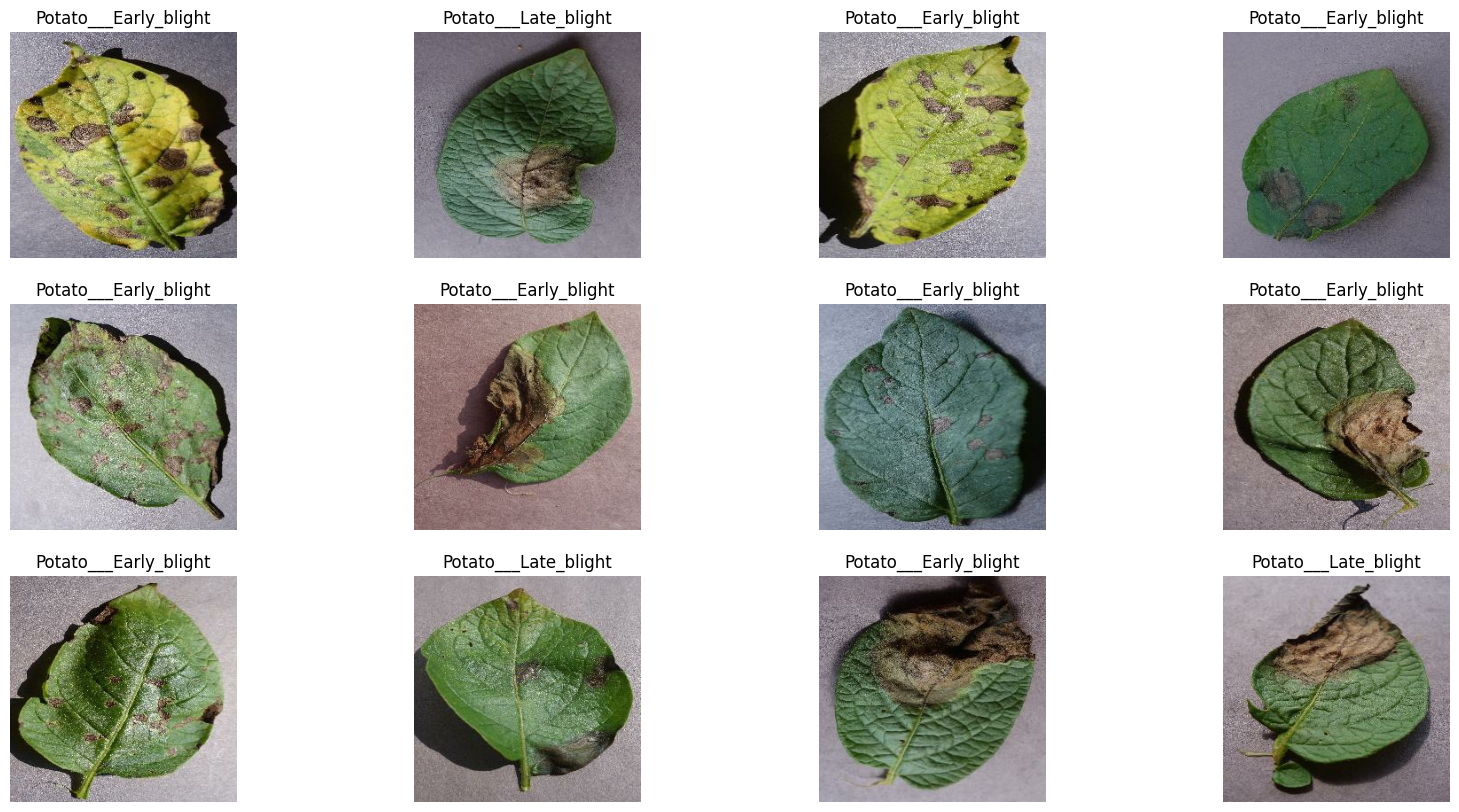

In [9]:
plt.figure(figsize=(20,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[labels_batch[i]])
        plt.axis('off')

In [10]:
# train_data=dataset.take(54)
# test_data=dataset.skip(54)

In [11]:
# val_data=test_data.take(6)
# test_ds=test_data.skip(6)

In [12]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
        assert (train_split + test_split + val_split) == 1

        ds_size=len(ds)#68
        if shuffle:
            ds = ds.shuffle(shuffle_size, seed=12)
        train_size=int(train_split*ds_size)#0.8*68=54
        val_size=int(val_split*ds_size)#0.1*68=6
        train_ds = ds.take(train_size) #54
        val_ds = ds.skip(train_size).take(val_size)#it will skip 54 and take 6
        test_ds = ds.skip(train_size).skip(val_size)#it will skip 54 and skip  6 and take 8
        return train_ds, val_ds, test_ds

In [13]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [14]:
len(train_ds)
len(val_ds)
len(test_ds)

8

In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(Image_Size, Image_Size),
  layers.Rescaling(1./255),
])

In [17]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
    layers.RandomTranslation(0.2, 0.2),
    # Add more data augmentation layers as needed
])

In [18]:
input_shape = (Image_Size, Image_Size, Channels)
batch_input_shape = (Batch_Size, Image_Size, Image_Size, Channels)
n_classes=3

In [19]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=batch_input_shape)

In [20]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_2 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
history = model.fit(
    train_ds,
    batch_size=Batch_Size,
    validation_data=val_ds,
    verbose=1,
    epochs=Epochs,
)

Epoch 1/5
54/54 [==============================] - 117s 2s/step - loss: 0.8656 - accuracy: 0.5093 - val_loss: 0.7446 - val_accuracy: 0.5260
Epoch 2/5
54/54 [==============================] - 80s 1s/step - loss: 0.6992 - accuracy: 0.6672 - val_loss: 0.7150 - val_accuracy: 0.6615
Epoch 3/5
54/54 [==============================] - 79s 1s/step - loss: 0.5335 - accuracy: 0.7558 - val_loss: 0.5198 - val_accuracy: 0.7760
Epoch 4/5
54/54 [==============================] - 87s 2s/step - loss: 0.4356 - accuracy: 0.8050 - val_loss: 0.4700 - val_accuracy: 0.7552
Epoch 5/5
54/54 [==============================] - 85s 2s/step - loss: 0.3563 - accuracy: 0.8524 - val_loss: 0.3164 - val_accuracy: 0.8542


In [20]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

[INFO] Calculating model accuracy
8/8 [==============================] - 10s 266ms/step - loss: 0.3586 - accuracy: 0.8398
Test Accuracy: 83.98%


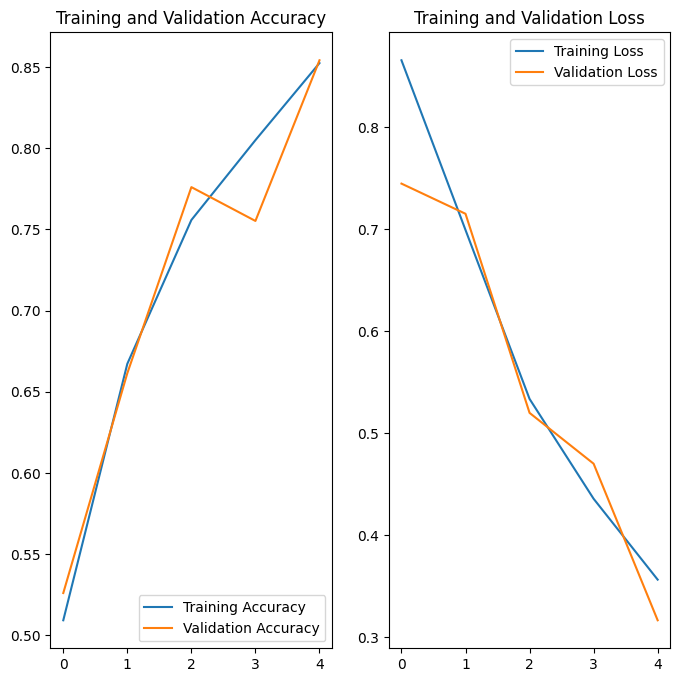

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(Epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [37]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class

1/1 [==============================] - 0s 47ms/step


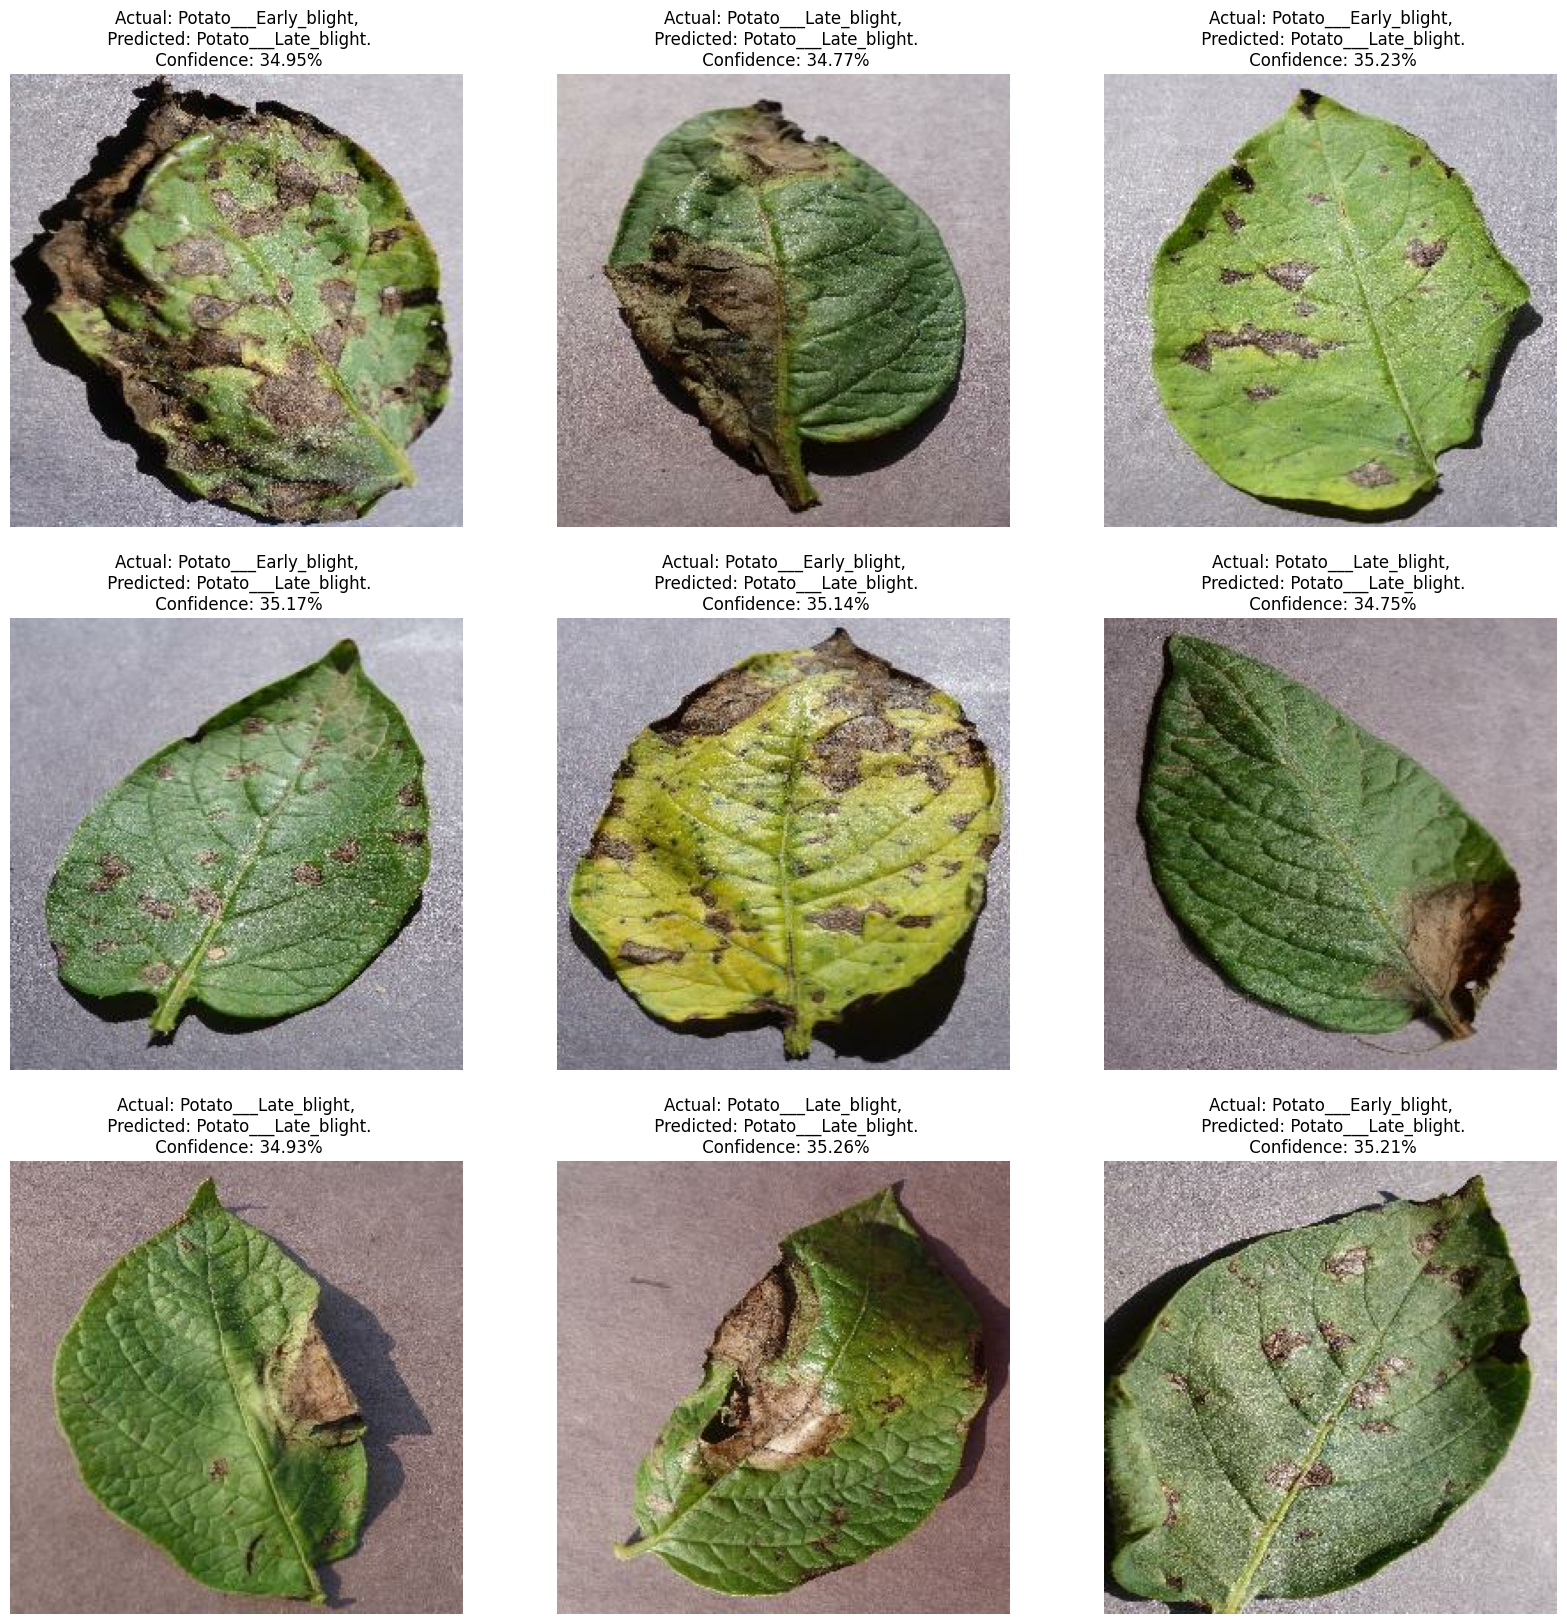

In [34]:
plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        
        actual_class = class_name[labels[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

image_path = r"D:\project_machine_vision\potato_disease\PlantVillage\Potato___Late_blight\00b1f292-23dd-44d4-aad3-c1ffb6a6ad5a___RS_LB 4479.JPG"
image = Image.open(image_path)

image_np = np.array(image)
image_np_uint8 = image_np.astype("uint8")

plt.imshow(image_np_uint8)
predicted_class=

In [38]:
predicted_class=predict(model,image_np )
predicted_class

1/1 [==============================] - 0s 47ms/step


'Potato___Late_blight'

In [40]:
import pickle
pickle.dump(predict,open("model.pkl","wb"))

In [23]:
model.save("model.h1")

INFO:tensorflow:Assets written to: model.h1\assets


INFO:tensorflow:Assets written to: model.h1\assets
